In [2]:
# Import Julia packages
using DrWatson
@quickactivate
using Revise
using LinearAlgebra
using DelimitedFiles
using SparseArrays
using StaticArrays
using BlockArrays
using CairoMakie
using UnPack
using FromFile
using GeometryBasics
using Random
using Colors
using JLD2
using LaTeXStrings
using Glob
using Printf
using ColorSchemes
using Statistics
using CircularArrays
using Random
using Distributions




@from "$(projectdir())/src/VertexModelContainers.jl" using VertexModelContainers
@from "$(projectdir())/src/Laplacians.jl" using Laplacians
@from "$(projectdir())/src/AnalysisFunctions.jl" using AnalysisFunctions
@from "$(projectdir())/src/CellProperties.jl" using CellProperties
@from "$(projectdir())/src/spatialData.jl" using SpatialData

In [11]:
function get_vert_order(A,B, i)
    # Find all edges and vertices for cell i
    cellEdges, edgeOrientations = findnz(B[i, :])
    N = length(cellEdges)

    orderedVerticesAroundEdges = zeros(Int64, N, 2)
    # orderedVerticesAroundEdges = MMatrix{N,2,Int64}(zeros(Int64,N,2))
    for j = 1:N
        verts, orients = findnz(A[cellEdges[j], :])
        orderedVerticesAroundEdges[j, :] = verts[sortperm(edgeOrientations[j] .* orients)]
    end

    orderedVerts = CircularArray(ones(Int64, N)) # Ordered list of vertices around cell i in clockwise direction 
    orderedEdges = CircularArray(ones(Int64, N)) # Ordered list of edges around cell i in clockwise direction

    for j = 1:N
        orderedVerts[j] = orderedVerticesAroundEdges[orderedEdges[j-1], 2]
        orderedEdges[j] = findfirst(x -> x == orderedVerts[j], @view orderedVerticesAroundEdges[:, 1])
    end
    orderedEdges .= cellEdges[orderedEdges[0:N-1]]

    return orderedVerts, orderedEdges
end

function new_cev_vecs(A, B)
    nVerts=size(A)[2]
    nEdges=size(A)[1]
    nCells=size(B)[1]
    edgesP=vec((abs.(ones(nCells)'*B)))
    vertsP=vec((0.5.*edgesP'*abs.(A))')
    edgesB=vec(abs.(A*(ones(nVerts).-vertsP)))
    edgesI=vec(ones(nEdges).-edgesB.-edgesP)
    vertsI=vec(ones(nVerts)-vertsP)
    cellsB=vec(abs.(abs.(B)*edgesP))
    cellsB[findall(x->x!=0,cellsB)].=1
    cellsI=ones(nCells)-cellsB
    
    edgesI=((abs.(B))'*Diagonal(cellsI)*abs.(B))*edgesI
    edgesI[findall(x->x!=0, edgesI)].=1


    vertsI=((abs.(A))'*Diagonal(edgesI)*abs.(A))*vertsI
    vertsI[findall(x->x!=0, vertsI)].=1


    return edgesP, edgesB, edgesI, vertsP, vertsI, cellsB, cellsI
end

function update_matrices(A, B,R, cellsI, edgesI, vertsI)
    Bint=B[cellsI.>0, edgesI.>0]
    Aint=A[edgesI.>0, vertsI.>0]
    Rint=R[vertsI.>0]
    nCellsint=size(Bint)[1]
    vert_order_int=[vec(get_vert_order(Aint,Bint, i)[1]) for i in 1:nCellsint]
    return Aint, Bint,Rint, nCellsint, vert_order_int
end

function get_Polygons(R,nCells, cellVertexOrders)
    cellPolygons = Vector{Point{2,Float64}}[]
    for i=1:nCells
        push!(cellPolygons,Point{2,Float64}.(R[cellVertexOrders[i]]))
    end
    return cellPolygons
end


get_Polygons (generic function with 1 method)

In [25]:
f=Glob.glob("quadratic_energy/grow/L₀=0.753_nCells=7_realTimetMax=346000.0_γ=0.172_24-06-29-12-35-41","C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims" )[end]
ff=Glob.glob("frameData/systemData*.jld2",f)[end]
@unpack R, matrices, params = load(ff)
@unpack nCells,nVerts, nEdges, γ, L₀ = params
@unpack cellAreas,cellPerimeters, cellTensions, cellPressures, cellEdgeCount, cellVertexOrders,edgeTangents,vertexAreas,boundaryEdges, boundaryVertices,A,Ā,B,B̄,C, ϵ = matrices


┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605
┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


Reconstruct@MatricesContainer(Any[sparse([1, 169, 2621, 2, 1292, 2810, 2, 221, 1958, 3, 524, 2324, 4, 87, 1568, 6, 17, 506, 8, 797, 2963, 9, 273, 2114, 11, 174, 737, 14, 194, 1541, 16, 1675, 2649, 16, 18, 2054, 19, 2246, 2463, 41, 881, 2850, 327, 1728, 1761, 13, 1826, 2610, 25, 123, 2195, 27, 202, 1132, 45, 1253, 2417, 30, 1490, 1562, 81, 97, 159, 7, 211, 1491, 584, 1220, 1613, 3, 404, 455, 22, 82, 2204, 26, 39, 2780, 19, 2247, 2508, 38, 1290, 1817, 14, 44, 1829, 25, 27, 2120, 21, 1871, 1874, 48, 1682, 2750, 49, 50, 232, 49, 126, 1913, 420, 636, 1188, 608, 1605, 2571, 56, 86, 2885, 57, 1338, 2482, 494, 1433, 2330, 58, 512, 2402, 728, 2089, 2090, 168, 2176, 2177, 64, 65, 2228, 66, 1190, 1409, 67, 642, 2714, 666, 1322, 1325, 15, 1547, 1727, 156, 573, 2948, 73, 1342, 1343, 73, 1166, 2408, 1302, 1928, 2789, 12, 76, 1346, 79, 2066, 2495, 32, 79, 1287, 82, 2147, 2684, 13, 84, 2609, 934, 1983, 2886, 23, 1244, 1955, 88, 89, 90, 88, 798, 2681, 62, 92, 1328, 29, 124, 2510, 197, 421, 2126, 51, 96

In [26]:
edgesP, edgesB, edgesI, vertsP, vertsI, cellsB, cellsI=new_cev_vecs(A,B);
Aint, Bint,Rint, Nc, vert_order=update_matrices(A, B,R, cellsI, edgesI, vertsI);
nCells = size(Bint, 1)
nEdges = size(Aint, 1)
nVerts = size(Aint, 2)


cellTimeToDivide = rand(Uniform(0.0,0.1*5000),size(B,1))
matrices = MatricesContainer(
    Aint,
    Bint,
    spzeros(Int64, nVerts, nEdges),                       # Aᵀ
    spzeros(Int64, nEdges, nVerts),                       # Ā
    spzeros(Int64, nVerts, nEdges),                       # Āᵀ
    spzeros(Int64, nEdges, nCells),                       # Bᵀ
    spzeros(Int64, nCells, nEdges),                       # B̄
    spzeros(Int64, nEdges, nCells),                       # B̄ᵀ
    spzeros(Int64, nCells, nVerts),                       # C
    zeros(Int64, nCells),                                 # cellEdgeCount
    fill(CircularVector(Int64[]), nCells),                # cellVertexOrders
    fill(CircularVector(Int64[]), nCells),                # cellEdgeOrders
    zeros(Int64, nVerts),                                 # boundaryVertices
    zeros(Int64, nEdges),                                 # boundaryEdges
    fill(SVector{2,Float64}(zeros(2)), nCells),           # cellPositions
    zeros(nCells),                                        # cellPerimeters
    fill(SMatrix{2,2,Float64}(zeros(2,2)), nCells),       # cellOrientedAreas
    zeros(nCells),                                        # cellAreas
    zeros(nCells),                                        # cellTensions
    zeros(nCells),                                        # cellPressures
    cellTimeToDivide,                                     # cellTimeToDivide
    ones(nCells),                                         # μ
    γ.*ones(nCells),                                      # Γ
    zeros(nEdges),                                        # edgeLengths
    fill(SVector{2,Float64}(zeros(2)), nEdges),           # edgeTangents
    fill(SVector{2,Float64}(zeros(2)), nEdges),           # edgeMidpoints
    spzeros(SVector{2,Float64}, nCells, nVerts),          # edgeMidpointLinks
    zeros(nEdges),                                        # timeSinceT1
    ones(nVerts),                                         # vertexAreas
    spzeros(SVector{2,Float64}, nVerts, nCells),          # F
    fill(SVector{2,Float64}(zeros(2)), nVerts),           # externalF
    fill(SVector{2,Float64}(zeros(2)), nVerts),           # totalF
    SMatrix{2, 2, Float64}([                              # ϵ Clockwise rotation matrix setting orientation of cell faces
    0.0 1.0
    -1.0 0.0
    ])        )


    params = ParametersContainer(
        "test",
        nCells,
        nEdges,
        nVerts,
        γ,
        params.λ,
        L₀,
        1.0,
        0.0,
        100,
        params.outputInterval,
        params.viscousTimeScale,
        params.realTimetMax,
        params.tMax,
        params.realCycleTime,
        params.nonDimCycleTime,
        params.t1Threshold,
        params.peripheralTension,
        params.seed,
        LogNormal(0.0, 0.2)
    )
R=Rint

jldsave(datadir(f,"systemData_internal_cells.jld2");matrices,params,R)


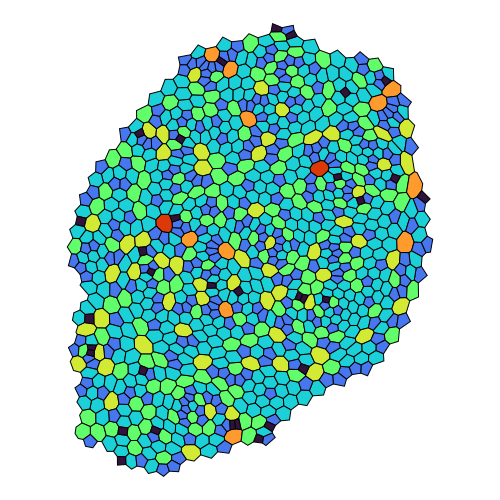

In [27]:
vert_order=[vec(get_vert_order(Aint,Bint, i)[1]) for i in 1:nCells]
cellPolygons = get_Polygons(Rint,nCells, vert_order)

set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(500,500))

a1=Axis(fig[1,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)

for i=1:nCells
    poly!(a1,cellPolygons[i], color=cellEdgeCount[cellsI.>0][i], colorrange=(4, 11),colormap=cgrad(ColorSchemes.turbo, 8, categorical=true),strokecolor=:black, strokewidth=1)
end


resize_to_layout!(fig)
fig

In [24]:
maximum(cellEdgeCount)

12